# Task Description

Marketing is trying to identify pickup location ids to incentivise passengers in
order to increase the number of trips. 

By using 2020 March to August Yellow
Cabs transactions build a recommendation engine to help marketing identify
these potential location ids on a weekly basis? 

Also define why you think
these areas are potential areas to incentivise according to you?

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
import matplotlib.transforms as transforms
import numpy as np

from util import agg_to_weekly_forecast, agg_to_weekly_actuals, get_model_forecast

# unfortunately prophet doesn't have a verbose param, so it is not easy to disable the logs... ---.--- 
import logging, sys
logging.disable(sys.maxsize)
import warnings; warnings.simplefilter('ignore')
%matplotlib inline


Importing plotly failed. Interactive plots will not work.


In [2]:
def ecdf(a):
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return np.cumsum(x * counts), cusum 

import matplotlib.pyplot as plt

def plot_cdf(pu_freq):
    x, y = ecdf(pu_freq)
    x = np.insert(x, 0, x[0])
    y = np.insert(y, 0, 0.)
    fig, ax = plt.subplots(figsize=(16,10))
    ax = sns.lineplot(x, y, drawstyle='steps-post', linewidth = 2.5)
    plt.axhline(222, c='red', ls='--')
    plt.grid(True)
    trans = transforms.blended_transform_factory(
    ax.get_yticklabels()[0].get_transform(), ax.transData)
    ax.text(0,222, "{:.0f}".format(222), color="red", transform=trans, 
            ha="right", va="center")
    plt.xlabel('Number of Taxi Rides', fontsize=20)
    plt.ylabel('Number of Pick-up Locations', fontsize=20)
    plt.show()
    
def shift_regressors(df, regressors, days):
    for regressor in regressors:
        df[regressor] = df[regressor].shift(days, fill_value=0)
    return df

In [3]:
data = pd.read_pickle('../data/full_cleaned_trip_data.pkl')

### Locations by Trip Frequency

Text(3.674999999999997, 0.5, 'Location Count')

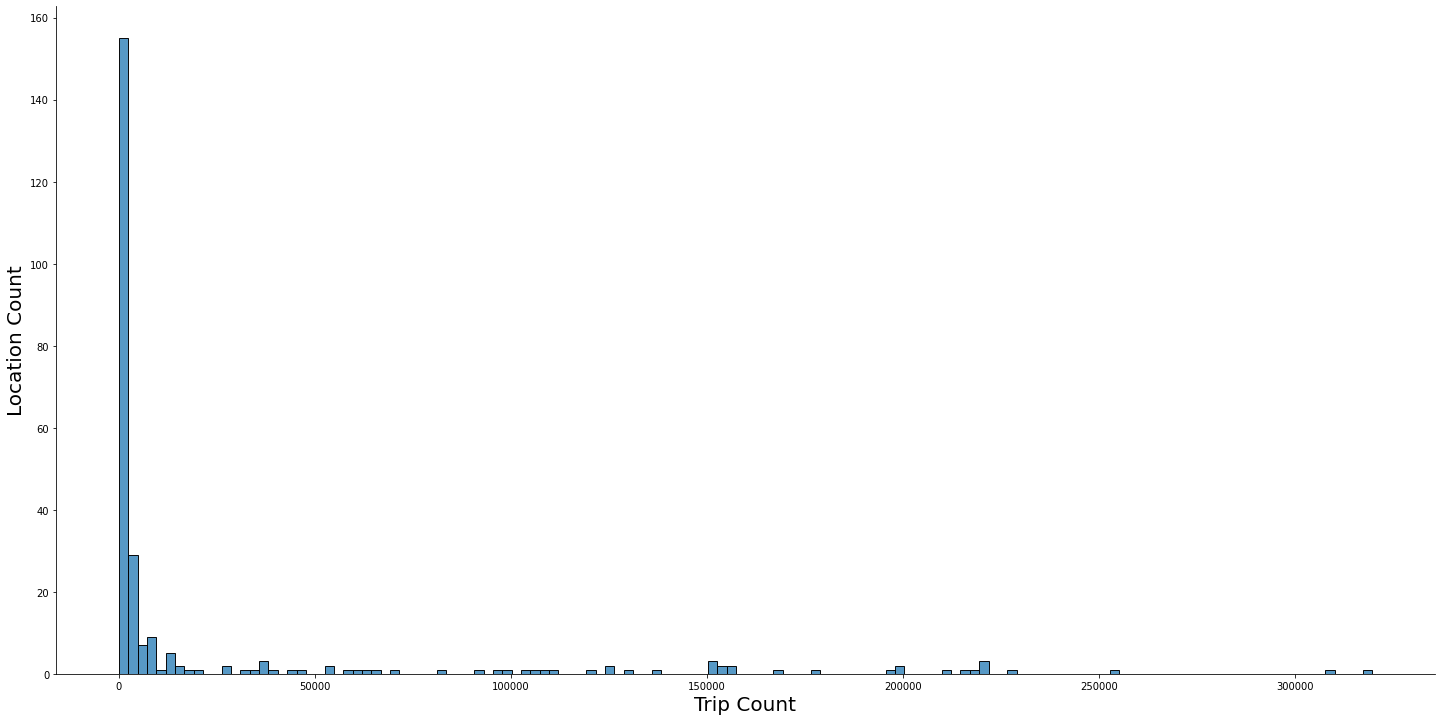

In [4]:
sns.displot(x=data.PULocationID.value_counts(), height=10, aspect=2)
plt.xlabel('Trip Count', fontsize=20)
plt.ylabel('Location Count', fontsize=20)

##### We can clearly see that the majority of Locations contribute to less than `10_000`  or even `1_000 `trips `per year`. I show this from a different angle below. 

#### Number of pick-up locations

In [5]:
data.PULocationID.nunique()

262

### Departures per location 

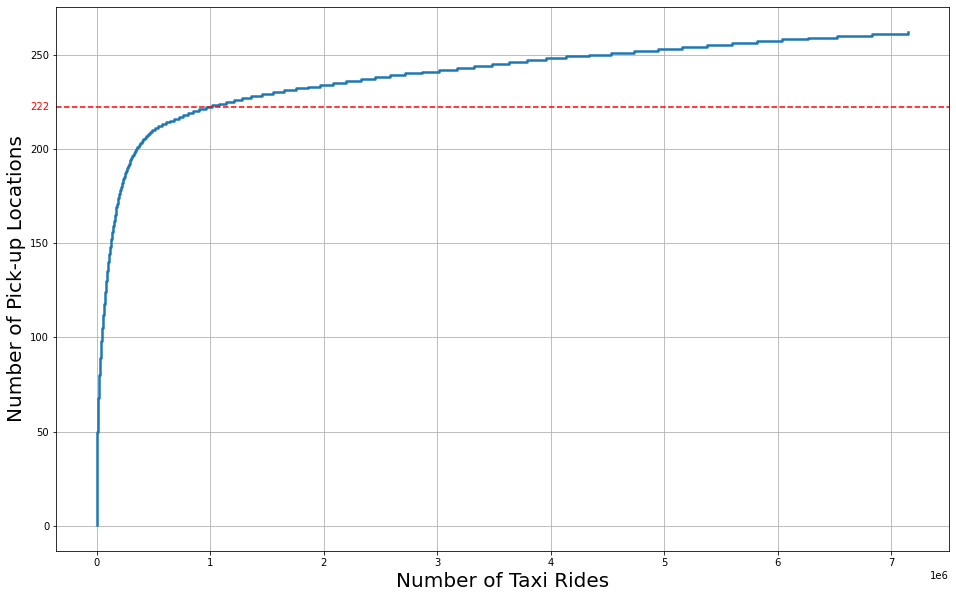

In [6]:
plot_cdf(data.PULocationID.value_counts())

##### From here, we can see that `222 Locations` (below the red line) generate "just" `1_000_000` rides. Where the `other 40 PU Locations` create the `remaining 6_000_000`.

# How and Where to Incentivise? 

I would focuse on the `top 40 locations`, because we know that the majority of our customer base is present there. 

We know that there is an existing high demand on these locations and it is unlikely that our service is the only one available to the customers. Therefore, simply applying a discount woucher (for example) would raise the amount of trips. 

However, I wouldn't necessarily incentivase the top of the top locations. Because we would in many cases  incentivise customers who would anyways use the service. 

I would rather look at the **top destinations of the top pickup locations**, because we know two things:
* the cabs are often there 
* we know our customers are there, because we deliver many of them to these locations

The condition for the **top destinations** to be recommended is that:
* they are not in the top 10 Pick-up locations -> Their rank is between position 10-40

The recommendations are then ranked by their forecasted departures. 

My expectation would be that we would better utilize our taxies and increase the response rate on such locations. 

# Solution

Develop a recommendation system that ranks PU locations based on predicted demand in the upcomming weeks. 

For this, we can leverage the model created for the purpose of the first task. Just this time we would train the model with seperate data for each location.  

The `effect` could be measured after the incentive is applied, to see if the number of rides is significantly higher then the predicted.

# Pick-Up Location Incentivisation Recommender (top 40 locations)

##### The main steps are broaken down in the `run_recom_pipeline`

### Adding external data for ride prediction purposes

In [7]:
def append_week_order(df):
    df_week_order = df.drop_duplicates(subset=['ds'])[['ds']].sort_values('ds')
    df_week_order['week_order'] = df_week_order['ds'].rank()
    return df.merge(df_week_order, on='ds')

class PulRecom:

    def __init__(self, data, covid_data, mobility_data, regressors, top_location_count=40):

        self.data = data
        self.df_covid = covid_data
        self.df_mobility = mobility_data
        self.regressors = regressors
        self.top_location_ids = data.PULocationID.value_counts().head(top_location_count).index
        self.weekly_top_pu = pd.DataFrame()
        self.top_pu_do_connections = pd.DataFrame()
        self.candidates = pd.DataFrame()
        
    def aggregate_daily_transaction_data(self, pu_id):
        """ Aggregates all daily transactions for specified PU Location ID returning a ds - > y 
        NOTE: We use 'ds' and 'y' because that's what Prophet requires
        """
        df = self.data[self.data['PULocationID'] == pu_id]
        return df.groupby(['ds']).agg(y=('PULocationID', 'count')).reset_index()


    def forecast_future_pu_demand(self, first_future_date):
        """ Creates weekly forecasts of departures for all the loaded top PU locations for the 
        next (future) month. 
        """
        forecast_df_lst = []

        for pu_id in self.top_location_ids:
            df_daily = self.aggregate_daily_transaction_data(pu_id)
            # adding external data -> regressors
            df_daily = df_daily.merge(self.df_covid).merge(self.df_mobility)
            # adding lag to the regressors
            df_daily = shift_regressors(df_daily, self.regressors, 30)
            
            df_train = df_daily[df_daily['ds'] < pd.to_datetime(first_future_date)]
            df_predict = df_daily[df_daily['ds'] >= pd.to_datetime(first_future_date)]

            m, forecast = get_model_forecast(df_train, df_predict, self.regressors) # not clean (but it's a hackaton)

            forecast_w = agg_to_weekly_forecast(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
            forecast_w = forecast_w.rename(columns={'yhat': 'expected_departures'})
            forecast_w['pu_id'] = pu_id

            forecast_df_lst.append(forecast_w[['ds', 'pu_id', 'expected_departures']])

        forecasts = pd.concat(forecast_df_lst)
        return forecasts.sort_values('expected_departures', ascending=False)
    

    def generate_top_pu_weekly(self, top_x=10):
        """Computes and outputs a pd.DataFrame containing the PU locations with the highes forecasted departures"""
        weekly_top_pu = self.forecasts.groupby('ds').head(top_x).sort_values('ds')
        weekly_top_pu['location_rank'] = weekly_top_pu.groupby('ds')['expected_departures'].rank(ascending=False)
        weekly_top_pu = append_week_order(weekly_top_pu)

        return weekly_top_pu
    
    def pick_top_do_for_top_pu(self, recom_count):
        """Selects the DO Locations with the highest number of arrivals from the top PU locations
           The DO Locations can not contain the PU locations with the most departures.
           The DO Locations are ranked based on their forecasted departures 
        """
        self.top_pu_do_connections = self.get_top_connections()
        candidates = self.weekly_top_pu.merge(self.top_pu_do_connections, left_on=['pu_id'],
                                             right_on=['PULocationID'])
        # we only want to consider DO Locations that are not the top 10 PU Locations
        candidates = candidates[~candidates['DOLocationID'].isin(self.weekly_top_pu['pu_id'])]

        # it is possible that the same DO Location has arrivals from multiple top PU so we need to aggregate that
        candidates = candidates.groupby([
                                    'ds',
                                    'week_order',
                                    'DOLocationID']).agg(top_pu_arrivals=('dest_freq', 'sum'),
                                                        top_pu_sources=('PULocationID', 'count')).reset_index()
        # we are adding the forecasted departures for the DO Locations per week so we can rank below
        recoms = candidates.merge(self.forecasts,left_on=['DOLocationID', 'ds'],
                right_on=['pu_id', 'ds']).rename(columns={'expected_departures':'DO_expected_departures'})
        recoms = recoms[['ds', 'week_order','DOLocationID','top_pu_sources', 
                         'top_pu_arrivals','DO_expected_departures']]
        
        # we want to prioritize DO Locations with high 'expected departures' (forecasted departures)
        recoms = recoms.sort_values('DO_expected_departures', ascending=False)
        
        return recoms.groupby('ds').head(10)
        
    def get_top_connections(self, top_x=10):
        """Returns the top_x connections for each PU location. 
           A ride between one PU and DO location is a connection. 
           Top connections are the ones that repeat the most.
        """
        df_coo_dest_dep = self.data.groupby(['PULocationID',
                                             'DOLocationID']).agg(dest_freq=('ds', 'count')).reset_index()
        df_top_connections = df_coo_dest_dep.sort_values('dest_freq', ascending=False)
        return df_top_connections.groupby('PULocationID').head(top_x).reset_index()


    def run_recom_pipeline(self, first_future_date, top_pu=10, recom_count=10):
        """This is a brakedown of steps in the pipeline"""
        self.forecasts = self.forecast_future_pu_demand(first_future_date)
        self.weekly_top_pu = self.generate_top_pu_weekly(top_pu)
        
        self.recoms = self.pick_top_do_for_top_pu(recom_count)
        
    def return_recoms_for_week(self, week_number):
        """Returns a pd.DataFrame with top PU locations and their top DO locations (recommendations)
           for the specified week
        """
        top_pu = self.weekly_top_pu.query('week_order == @week_number')
        recoms = self.recoms.query('week_order == @week_number')
        return (top_pu, recoms)



In [8]:
df_covid = pd.read_pickle('../data/covid_daily_processed.pkl')
df_mobility = pd.read_pickle('../data/mobility.pkl')

In [9]:
data['ds'] = data['tpep_pickup_datetime'].dt.date

We would use the same reggressors as in the first task, because they were shown to be useful for predicting the rides.

In [10]:
regressors = [
    'retail_mobility',
    'residential_mobility',
    'transit_mobility',
    'CASE_COUNT_7DAY_AVG',
]

# Usage

The class instance keeps state of the input data, and the downstream transformations (check constructor for more clarity)

In [11]:
pulr = PulRecom(data, df_covid, df_mobility, regressors, top_location_count=40)

#### To run the recom pipeline we need to specify the `number of top_pu locations` and the `first date` for the one month period in which we would recommend Pick-Up Locations to incentivise

In [12]:
pulr.run_recom_pipeline('2020-09-01', top_pu=5)

# Recoms for Week 1 of September

In [13]:
top_pu, recoms = pulr.return_recoms_for_week(1)

In [14]:
top_pu

,ds,pu_id,expected_departures,location_rank,week_order
0,2020-09-06,236,9959.148252,2.0,1.0
1,2020-09-06,48,7310.284191,5.0,1.0
2,2020-09-06,141,7458.451264,4.0,1.0
3,2020-09-06,237,10761.623901,1.0,1.0
4,2020-09-06,186,8893.480040,3.0,1.0


## These would be the Locations to incentivise as Pick-up locations

In [15]:
recoms

,ds,week_order,DOLocationID,top_pu_sources,top_pu_arrivals,DO_expected_departures
5,2020-09-06,1.0,140,3,37367,6855.290578
8,2020-09-06,1.0,162,4,46945,6809.622637
6,2020-09-06,1.0,142,2,21003,6799.323786
18,2020-09-06,1.0,263,3,42511,6713.819937
15,2020-09-06,1.0,239,2,19610,6566.857850
14,2020-09-06,1.0,238,1,12781,6029.448854
13,2020-09-06,1.0,234,1,8911,5954.945959
3,2020-09-06,1.0,107,1,8953,5574.385036
10,2020-09-06,1.0,229,2,21866,5058.937163
1,2020-09-06,1.0,68,2,22487,4875.294321


In [16]:
# Recoms for Week 4 of September

In [17]:
top_pu, recoms = pulr.return_recoms_for_week(4)

In [18]:
top_pu

,ds,pu_id,expected_departures,location_rank,week_order
15,2020-09-27,237,15541.803607,1.0,4.0
16,2020-09-27,48,11187.045187,4.0,4.0
17,2020-09-27,186,11498.026753,3.0,4.0
18,2020-09-27,236,14677.729737,2.0,4.0
19,2020-09-27,161,9808.201853,5.0,4.0


In [19]:
## These would be the Locations to incentivise as Pick-up locations

In [20]:
recoms

,ds,week_order,DOLocationID,top_pu_sources,top_pu_arrivals,DO_expected_departures
60,2020-09-27,4.0,140,2,26545,9499.447516
68,2020-09-27,4.0,234,2,18083,9371.612757
63,2020-09-27,4.0,162,3,37452,9339.717191
61,2020-09-27,4.0,142,2,21003,9159.519662
72,2020-09-27,4.0,263,2,27273,8940.556065
70,2020-09-27,4.0,239,2,19610,8530.902652
58,2020-09-27,4.0,107,1,8953,7862.533300
69,2020-09-27,4.0,238,1,12781,7593.819311
64,2020-09-27,4.0,163,1,6673,7123.390159
55,2020-09-27,4.0,68,2,22487,6910.239514
